
preprosessing the data


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from pathlib import Path


DATA_PATH = Path(r"F:\博士\ITS Ghana\Ghana 2\Ghana.zip\data\ITS Survey(1-494).xlsx")


META_COLS = [
    "ID",
    "Start time",
    "Completion time",
    "Email",
    "Name",
    "Last modified time",
]

Q_CONSENT = "If you have read the consent form, answer below."
Q_HEARD_ITS = "Have you ever heard of Intelligent Transportation Systems (ITS) prior to taking this survey?"
Q_APP_USE = "How often do you use transportation applications (e.g., Google Maps, Bolt, Uber)?"
Q_IMPROVE = "Do you think technology-based solutions (ITS) can improve transportation in Ghana?"
Q_INVEST = "Do you think the government should invest more in ITS for transportation improvement?"
Q_WOULD_USE = "If an ITS system (such as real-time bus tracking) was introduced in your community, would you use it?"
Q_LEARN = "Would you be interested in learning more about ITS and how it can impact transportation in Ghana?"

Q_FAMILIAR = "Which of the following ITS technologies are you familiar with? (Select all that apply)"
Q_CHALLENGES = "What are the biggest transportation challenges in your area? (Select all that apply)"
Q_IMPL_CHAL = "What are the biggest challenges to implementing ITS in Ghana? (Select all that apply)"
Q_COMMUTE = "How do you typically commute? (select all that applies)"

LIKERT_COLS = [
    "Traffic signals that adjust in real-time based on traffic conditions (smart traffic lights and adaptive signal control)",
    "Mobile apps that provide real-time bus and train arrival times for passengers",
    "Automatic toll collection and pricing systems to reduce traffic in congested areas",
    "Use of cameras and sensors to enforce traffic laws (e.g., speed limits, red lights)",
    "GPS tracking systems to monitor and manage public transportation fleets (buses and taxis)",
    "Testing or introducing self-driving and internet-connected vehicles on public roads",
]

Q_AREAS = "Are there any specific areas or cities in Ghana where you think ITS solutions would be most impactful? Please explain."
Q_SUGG_ITS = "Do you have any suggestions for how the government or private sector could better implement ITS solutions in Ghana?"
Q_FINAL_SUGG = "Do you have any suggestions or opinions on how transportation can be improved in Ghana using technology?"

Q_GREW_UP = "Which of the following best represents where you grew up?"
Q_LIVE_NOW = "Which of the following best describes where you currently live?"
Q_AGE = "Which of the following describes your age group?"
Q_GENDER = "What best describes your gender?"
Q_INCOME = "What is your approximate monthly income?"
Q_EDU = "What is the highest level of education you have obtained? (If pursuing a higher level of education currently, select that option)"
Q_UNI = "If you are a university student, which university?"
Q_FIELD = "If you have attended or are attending university, what is/was your field of study? Else, choose N/A"
Q_YEAR = "If you are attending university or any tertiary institution, what year of study are you in? Else, choose N/A"

LIKERT_MAP = {
    "Not Beneficial at all": 1,
    "Slightly Beneficial": 2,
    "Moderately Beneficial": 3,
    "Very Beneficial": 4,
    "Extremely Beneficial": 5,
}

# ===================== 数据加载与清洗 =====================
def _load_dataframe(path: Path) -> pd.DataFrame:
    """
    Read Excel, normalize headers, drop metadata columns
    """
    df = pd.read_excel(path)

    # 清理列名（去空格、合并换行）
    df.columns = (
        pd.Index(df.columns)
        .map(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )

    # 删除元数据列
    df = df.drop(columns=[c for c in META_COLS if c in df.columns], errors="ignore")
    return df

# ===================== mian data：df1 =====================
df1: pd.DataFrame = _load_dataframe(DATA_PATH)



# ===================== 辅助函数 =====================
def VC(df: pd.DataFrame, col: str) -> pd.Series:
    
    return df[col].dropna().astype(str).str.strip().value_counts()

def MC(df: pd.DataFrame, col: str) -> pd.Series:
    
    counter = Counter()
    for raw in df[col].dropna().astype(str):
        parts = re.split(r"[;\n]\s*", raw)
        parts = [p.strip() for p in parts if p.strip()]
        counter.update(parts)
    return pd.Series(counter).sort_values(ascending=False)

def likert_means(df: pd.DataFrame, cols=LIKERT_COLS, mapping=LIKERT_MAP) -> pd.Series:
   
    means = {}
    for c in cols:
        means[c] = df[c].map(mapping).mean()
    return pd.Series(means).dropna()

def bar_plot(series: pd.Series, title: str, outpath: str, rotate: int = 0, horizontal: bool = False):
    
    if series is None or series.empty:
        return
    vals = series.sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    if horizontal:
        plt.barh(range(len(vals)), vals.values)
        plt.yticks(range(len(vals)), vals.index)
        plt.xlabel("Value")
    else:
        plt.bar(range(len(vals)), vals.values)
        plt.xticks(range(len(vals)), vals.index, rotation=rotate, ha="right")
        plt.ylabel("Value")
    plt.title(title)
    plt.tight_layout()
    Path(outpath).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outpath, dpi=150)
    plt.close()


_STOPWORDS = set("""
the a an of and or to for in on at with by about from into through during before after
above below again further then once here there when where why how all any both each few
more most other some such no nor not only own same so than too very can will just don
should now is are was were be been being this that these those you your our their its
as if but do does did have has had him her them they we me my it
""".split())

def top_terms(df: pd.DataFrame, col: str, topn: int = 20) -> pd.Series:
    
    words = []
    for txt in df[col].dropna().astype(str):
        tokens = re.findall(r"[A-Za-z']{3,}", txt.lower())
        tokens = [t for t in tokens if t not in _STOPWORDS]
        words.extend(tokens)
    return pd.Series(Counter(words)).sort_values(ascending=False).head(topn)


SINGLE_SELECT_COLS = [
    Q_CONSENT, Q_HEARD_ITS, Q_APP_USE, Q_IMPROVE, Q_INVEST, Q_WOULD_USE, Q_LEARN,
    Q_GREW_UP, Q_LIVE_NOW, Q_AGE, Q_GENDER, Q_INCOME, Q_EDU, Q_UNI, Q_FIELD, Q_YEAR,
]

MULTI_SELECT_COLS = [Q_FAMILIAR, Q_CHALLENGES, Q_IMPL_CHAL, Q_COMMUTE]
OPEN_ENDED_COLS = [Q_AREAS, Q_SUGG_ITS, Q_FINAL_SUGG]


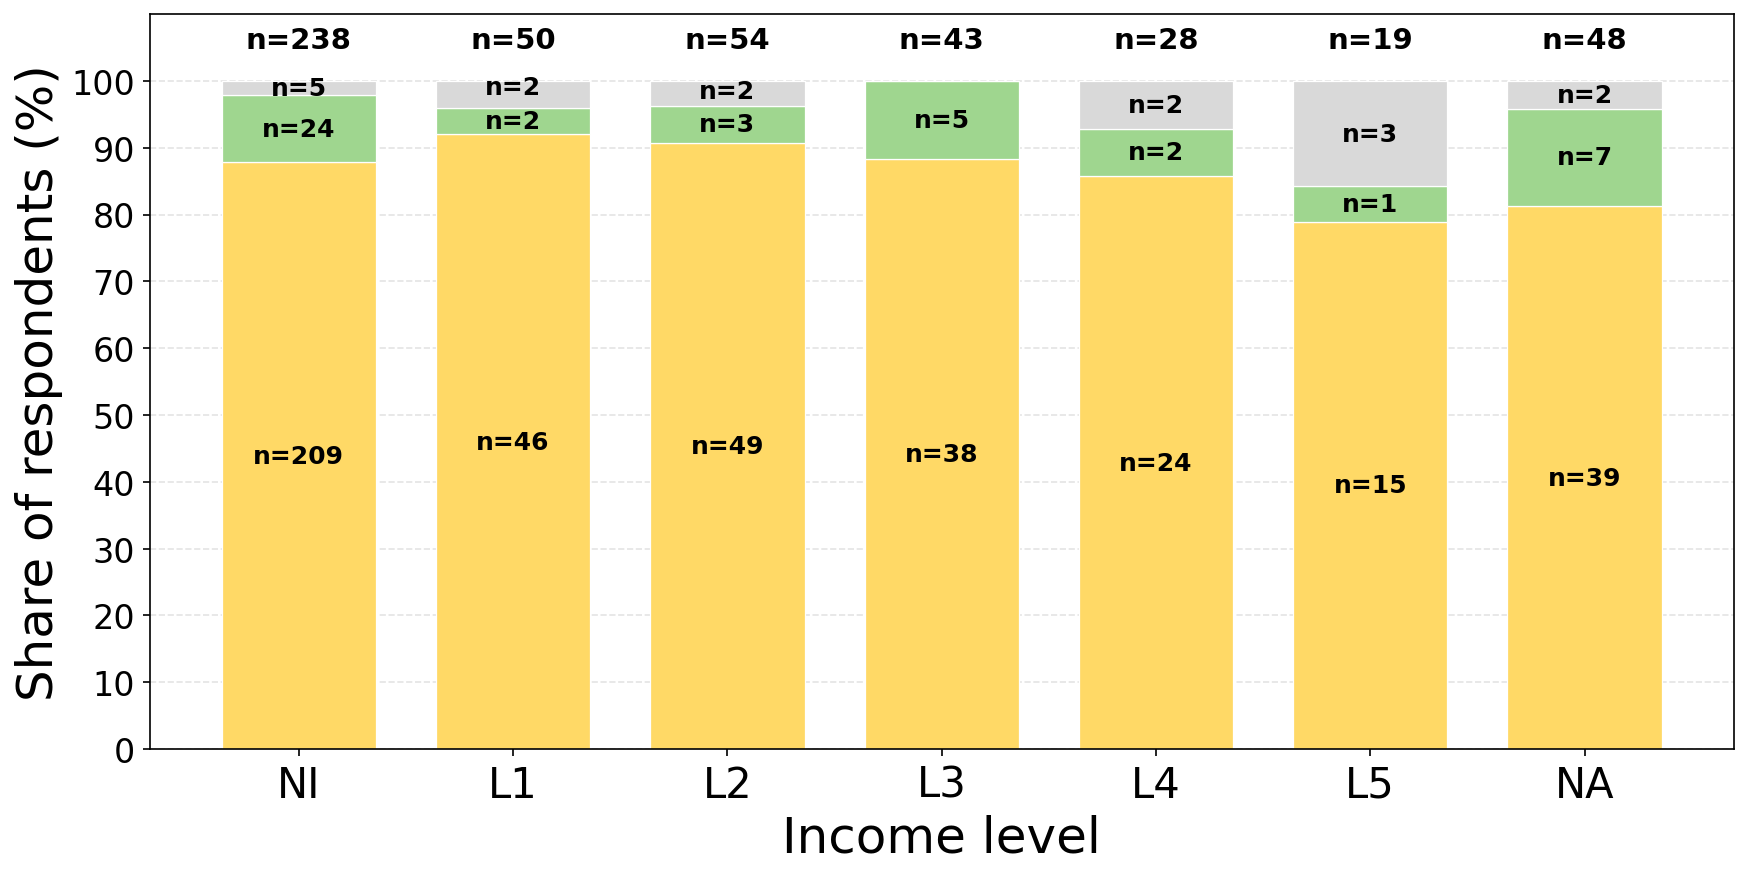

In [27]:

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from pathlib import Path

# ===================== 图表配置 =====================
WILL_ORDER = ["Yes", "Maybe", "No"]
PALETTE = {"Yes": "#FFD966", "Maybe": "#9FD68F", "No": "#D9D9D9"}  # 黄 / 绿 / 灰
FIGSIZE = (12, 7)
DPI = 150

INCOME_ORDER = [
    "No Income",
    "Less than GHS 1,000",
    "GHS 1,000 – 3,000",
    "GHS 3,000 – 6,000",
    "GHS 6,000 – 10,000",
    "More than GHS 10,000",
    "Prefer not to say",
]

# ============ 新的简洁收入标签（你要求的格式） ============
INCOME_SHORT = { 
    "No Income": "NI",
    "Less than GHS 1,000": "L1",
    "GHS 1,000 – 3,000": "L2",
    "GHS 3,000 – 6,000": "L3",
    "GHS 6,000 – 10,000": "L4",
    "More than GHS 10,000": "L5",
    "Prefer not to say": "NA",
}

# ===================== 标准化函数 =====================
def norm_income(v):
    import re
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return np.nan
    s = str(v).strip().lower().replace("--", "–").replace("-", "–")
    s = re.sub(r"\s+–\s+", " – ", s)
    if s.startswith("less than ghs 1,000"): return "Less than GHS 1,000"
    if "ghs 1,000" in s and "3,000" in s:  return "GHS 1,000 – 3,000"
    if "ghs 3,000" in s and "6,000" in s:  return "GHS 3,000 – 6,000"
    if "ghs 6,000" in s and "10,000" in s: return "GHS 6,000 – 10,000"
    if s.startswith("more than ghs 10,000") or "more than" in s:
        return "More than GHS 10,000"
    if s.startswith("no income"):         return "No Income"
    if "prefer not" in s:                 return "Prefer not to say"
    return s

def norm_will(v):
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return np.nan
    s = str(v).strip().lower()
    if s in {"yes", "y"}:              return "Yes"
    if s in {"maybe", "it depends"}:   return "Maybe"
    if s in {"no", "n"}:               return "No"
    return s.title()

# ===================== 数据处理 =====================
df = df1[[Q_INCOME, Q_WOULD_USE]].copy()
df["_INC"]  = df[Q_INCOME].map(norm_income)
df["_WILL"] = df[Q_WOULD_USE].map(norm_will)

df = df[df["_INC"].isin(INCOME_ORDER)].dropna(subset=["_WILL"])
df["_INC"]  = pd.Categorical(df["_INC"], categories=INCOME_ORDER, ordered=True)
df["_WILL"] = pd.Categorical(df["_WILL"], categories=WILL_ORDER, ordered=True)

ct_counts = pd.crosstab(df["_INC"], df["_WILL"]).reindex(index=INCOME_ORDER, columns=WILL_ORDER, fill_value=0)
totals = ct_counts.sum(axis=1)
ct_pct = (ct_counts.div(totals.replace(0, np.nan), axis=0) * 100).fillna(0)

x = np.arange(len(ct_counts.index))

# ===================== 绘图 =====================
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
bottom = np.zeros(len(ct_counts.index), dtype=float)

# 堆叠柱图
for cat in WILL_ORDER:
    vals = ct_pct[cat].values
    ax.bar(
        x, vals, bottom=bottom, width=0.72,
        color=PALETTE.get(cat, "#999999"),
        edgecolor="white", linewidth=0.6
    )
    bottom += vals

# ---------- 标签：只显示样本数（里面n=XX） ----------
MIN_GAP = 5
for i, inc in enumerate(ct_pct.index):
    cum = 0.0
    y_positions, labels = [], []
    for cat in WILL_ORDER:
        pct = float(ct_pct.loc[inc, cat])
        count = int(ct_counts.loc[inc, cat])
        if count == 0 or pct == 0:
            cum += pct
            continue
        y_positions.append(cum + pct / 2.0)
        labels.append(f"n={count}")
        cum += pct

    # 防止重叠
    for j in range(1, len(y_positions)):
        if y_positions[j] - y_positions[j - 1] < MIN_GAP:
            y_positions[j] = y_positions[j - 1] + MIN_GAP
    y_positions = np.clip(y_positions, 0, 100)

    for y, label in zip(y_positions, labels):
        ax.text(
            x[i], y, label,
            ha="center", va="center",
            fontsize=12, fontweight="bold",
            color="black"
        )

# ---------- 每组顶部样本总数 ----------
for i, inc in enumerate(ct_pct.index):
    total_n = int(totals.loc[inc])
    ax.text(
        x[i], 104, f"n={total_n}",
        ha="center", va="bottom",
        fontsize=14, color="black", fontweight="bold"
    )

# ===================== 修改后的 X 轴标签（你要求的部分） =====================
x_labels = [INCOME_SHORT[lbl] for lbl in INCOME_ORDER]
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=20)  # 字号增大

# ===================== Y 轴、美化 =====================
ax.set_ylabel("Share of respondents (%)", fontsize=24 )
ax.set_xlabel("Income level", fontsize=24)
ax.tick_params(axis="y", labelsize=16)

ax.set_ylim(0, 110)
ax.set_yticks(np.arange(0, 101, 10))
ax.yaxis.grid(True, linestyle="--", alpha=0.35)
ax.set_axisbelow(True)

# 去掉 legend
ax.set_title("")
if ax.get_legend(): ax.legend_.remove()

plt.subplots_adjust(bottom=0.25, left=0.10, right=0.98, top=0.95)
plt.show()


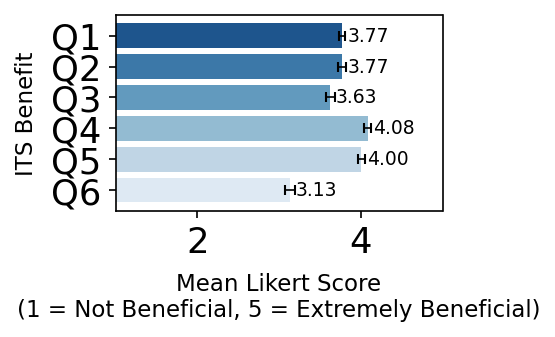

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===================== Prepare Likert data =====================

scores = df1[LIKERT_COLS].replace(LIKERT_MAP)

summary = scores.agg(['mean', 'count', 'std']).T
summary["se"] = summary["std"] / summary["count"] ** 0.5
summary["se"] = summary["se"].fillna(0)

q_map = {col: f"Q{i+1}" for i, col in enumerate(LIKERT_COLS)}
summary["Q"] = summary.index.map(q_map)

order = [f"Q{i}" for i in range(1, len(LIKERT_COLS) + 1)]
summary = summary.set_index("Q").loc[order].reset_index()

# ===================== Plotting =====================

plt.figure(figsize=(3.6, 2.8))

ax = sns.barplot(
    data=summary, y="Q", x="mean",
    orient="h", palette="Blues_r"
)

ax.errorbar(
    summary["mean"], range(len(summary)),
    xerr=summary["se"], fmt='none', ecolor='black',
    elinewidth=0.8, capsize=2.5
)

for i, row in summary.iterrows():
    ax.text(row["mean"] + 0.07, i, f"{row['mean']:.2f}",
            va="center", ha="left", fontsize=9)

ax.set_xlabel("Mean Likert Score\n(1 = Not Beneficial, 5 = Extremely Beneficial)",
              fontsize=11, labelpad=6)
ax.set_ylabel("ITS Benefit", fontsize=11, labelpad=6)
ax.set_xlim(1, 5)

plt.tight_layout(pad=1.5)
plt.show()   


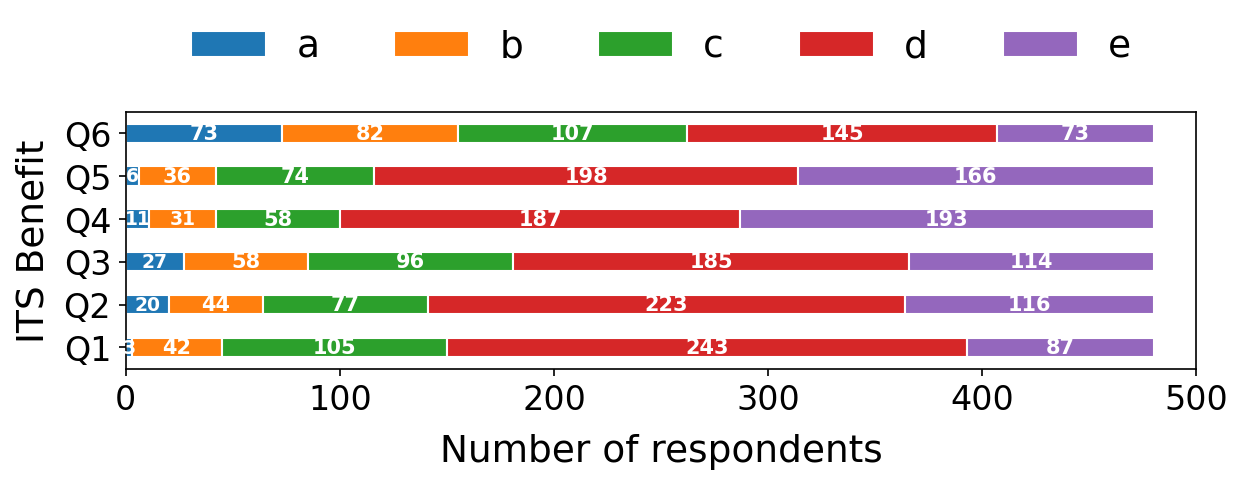

In [17]:

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "figure.dpi": 150,
})

# ===================== Prepare Likert data =====================
scores = df1[LIKERT_COLS].replace(LIKERT_MAP)
long_df = scores.melt(var_name="Question", value_name="Score").dropna()

counts = (
    long_df.groupby(["Question", "Score"])
           .size()
           .reset_index(name="Count")
)

all_idx = pd.MultiIndex.from_product([LIKERT_COLS, range(1, 6)],
                                     names=["Question", "Score"])

counts = (
    counts.set_index(["Question", "Score"])
          .reindex(all_idx, fill_value=0)
          .reset_index()
)

q_map = {col: f"Q{i+1}" for i, col in enumerate(LIKERT_COLS)}
counts["Q"] = counts["Question"].map(q_map)

# Likert palette
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
labels = ["a", "b", "c", "d", "e"]   

def ideal_text_color(hex_color: str) -> str:
    r, g, b = to_rgb(hex_color)
    luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return "black" if luminance > 0.6 else "white"

# ===================== Plotting =====================
plt.figure(figsize=(8.8, 3.8))
Qs = sorted(counts["Q"].unique())
lefts = {q: 0 for q in Qs}

for score in range(1, 6):
    sub = counts[counts["Score"] == score].sort_values("Q")
    color = palette[score - 1]

    bars = plt.barh(
        sub["Q"], sub["Count"],
        left=[lefts[q] for q in sub["Q"]],
        color=color, edgecolor="white", height=0.45,
        label=labels[score - 1]  
    )

    for bar, cnt in zip(bars, sub["Count"]):
        if cnt > 0:
            cx = bar.get_x() + bar.get_width() / 2
            cy = bar.get_y() + bar.get_height() / 2
            fontsize = 9 if bar.get_width() < 35 else 10
            plt.text(cx, cy, f"{cnt}",
                     ha="center", va="center",
                     color=ideal_text_color(color),
                     fontsize=fontsize, fontweight="bold")

    for q, w in zip(sub["Q"], sub["Count"]):
        lefts[q] += w


plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=5,
    frameon=False,
    fontsize=18,
    title_fontsize=18
)

# ===================== Axes =====================
plt.xlabel("Number of respondents", fontsize=18, labelpad=8)
plt.ylabel("ITS Benefit", fontsize=18, labelpad=6)

xmax = max(counts.groupby("Q")["Count"].sum())
xmax_rounded = int(round(xmax / 100.0) * 100)
plt.xlim(0, xmax_rounded)
plt.xticks(range(0, xmax_rounded + 1, 100))

plt.tight_layout(pad=1.6)
plt.show()


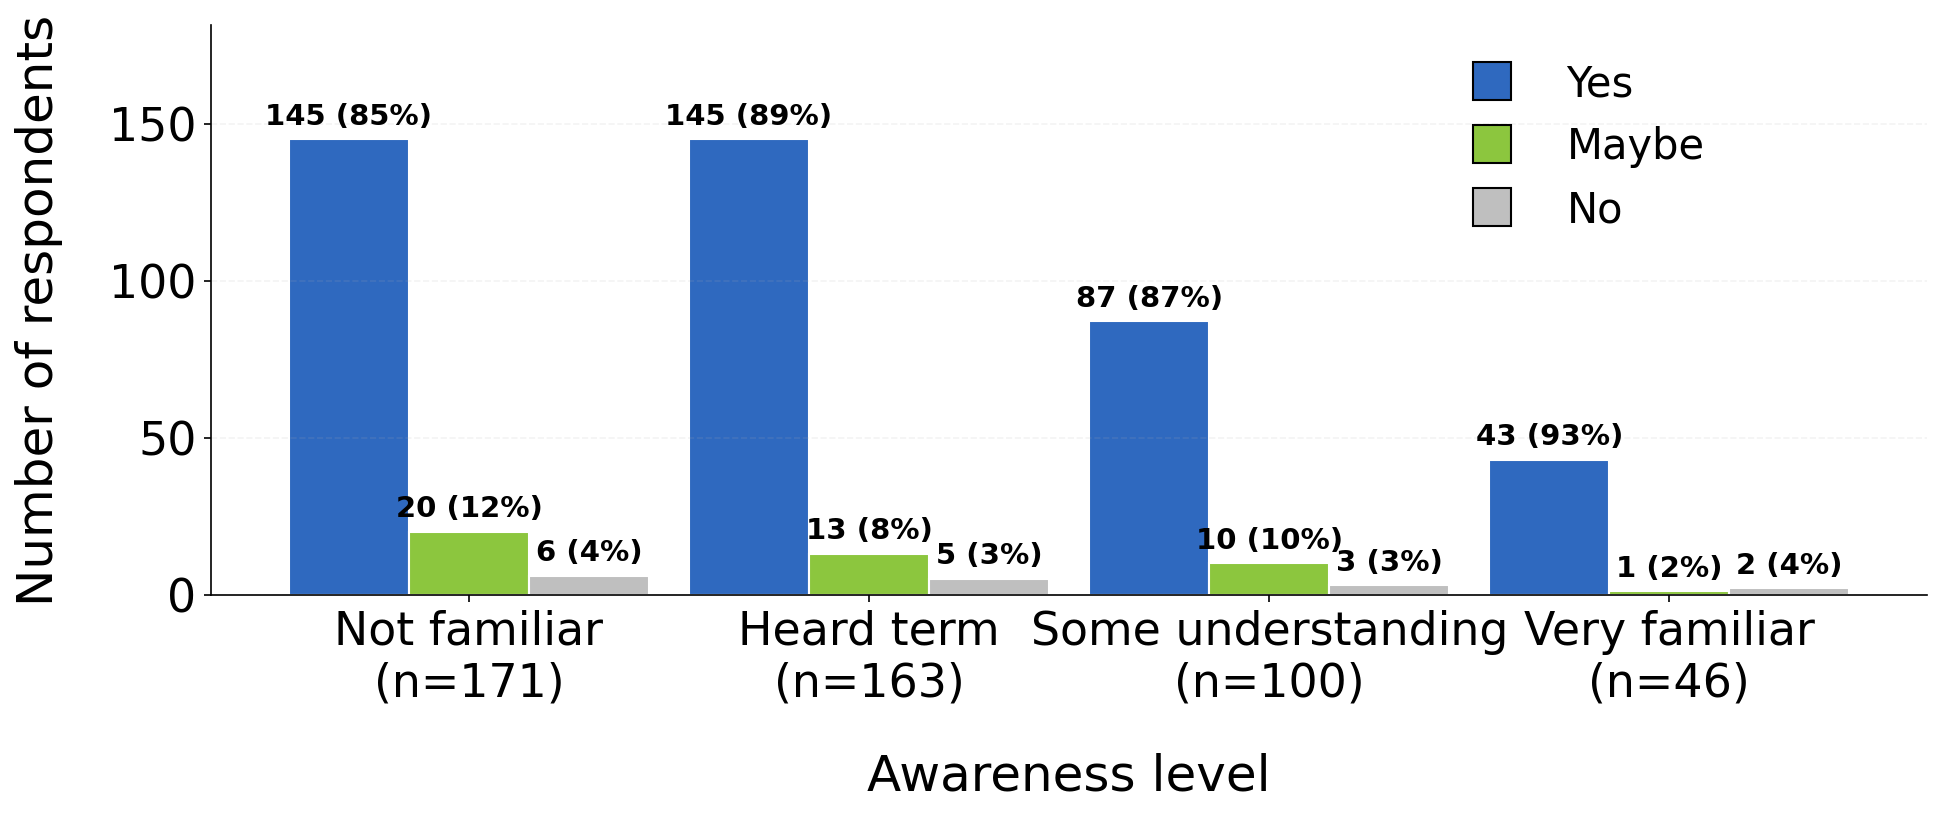

In [25]:

order_awareness = [
    "Not at all familiar",
    "Have heard the term but don't know what it means exactly",
    "Have some understanding of it",
    "Very familiar",
]
order_will = ["Yes", "Maybe", "No"]
short_names = ["Not familiar", "Heard term", "Some understanding", "Very familiar"]

# Extract needed columns
df = df1[[Q_HEARD_ITS, Q_WOULD_USE]].dropna().astype(str)

# Crosstab: Counts
ct_counts = (
    pd.crosstab(df[Q_HEARD_ITS], df[Q_WOULD_USE])
      .reindex(index=order_awareness, columns=order_will)
      .fillna(0).astype(int)
)

# Row totals & percentages
row_n = ct_counts.sum(axis=1)
ct_pct = ct_counts.div(row_n, axis=0).mul(100).round(0)

# ===================== Plotting =====================
fig, ax = plt.subplots(figsize=(13.5, 6.8))
colors = {"Yes": "#2F69BF", "Maybe": "#8CC63E", "No": "#BFBFBF"}

x = np.arange(len(short_names)) * 0.8

bar_w = 0.24
bars = {}

# Bar groups
for i, resp in enumerate(order_will):
    bars[resp] = ax.bar(
        x + (i - 1) * bar_w,
        ct_counts[resp].values,
        width=bar_w,
        color=colors[resp],
        edgecolor="white"
    )

# Add labels on bars
ymax = ct_counts.values.max()
for resp in order_will:
    for b, n, p in zip(bars[resp], ct_counts[resp].values, ct_pct[resp].values):
        ax.text(
            b.get_x() + b.get_width() / 2,
            b.get_height() + max(0.02 * ymax, 1.0),
            f"{n} ({int(p)}%)",
            ha="center", va="bottom",
            fontsize=14, fontweight="bold"
        )

# X-tick labels
xtick_labels = [f"{nm}\n(n={int(row_n.iloc[i])})" for i, nm in enumerate(short_names)]
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, fontsize=20 )

# Axis labels
ax.set_ylabel("Number of respondents", fontsize=24,  labelpad=22)
ax.set_xlabel("Awareness level", fontsize=24, labelpad=22)
ax.tick_params(axis="y", labelsize=22)
ax.tick_params(axis="x", labelsize=22)

ax.set_ylim(0, ymax * 1.25)

# Grid + remove top/right borders
ax.yaxis.grid(True, linestyle="--", alpha=0.15)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
# ====================== Add Legend (Right-Top) ======================
legend_handles = [
    plt.Line2D([0], [0], marker='s', color='none', label="Yes",
               markerfacecolor=colors["Yes"], markersize=18),
    plt.Line2D([0], [0], marker='s', color='none', label="Maybe",
               markerfacecolor=colors["Maybe"], markersize=18),
    plt.Line2D([0], [0], marker='s', color='none', label="No",
               markerfacecolor=colors["No"], markersize=18),
]

ax.legend(
    handles=legend_handles,
   
    title_fontsize=18,
    fontsize=20,
    frameon=False,
    bbox_to_anchor=(0.7, 1),  # 右上角
    loc="upper left",
)

# Layout
plt.tight_layout(rect=[0.02, 0.05, 1, 0.88])
plt.show()  # <-- only display
